## **Motivations**

Considering the challenge of building reliable confidence intervals for relative difference aka percent change (Y-X)/X

Running statistical simulations to measure the deviation in coverage rate of: 
- a "naive" percent change CI, directly derived from the CI of the absolute difference in means by dividing bounds by the mean of X
- from an (asymptotic) percent change CI formed with the delta method ([paper](https://arxiv.org/pdf/1803.06336.pdf)), with proper variance estimation

Working with binomial variables, as often in online experimentation settings (clickthrough rates)

Delta-method-based confidence interval for percent change (Y-X)/X:

<img src="delta_rel_diff_CI.png" align="left"/>


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt

In [5]:
np.random.seed(2023)

def run_bin_simulations(
    sample_sizes = [20, 50, 200, 2000, 5000, 25000],
    effect_sizes = np.arange(start=0.1, stop=1, step=0.1), # relative
    nb_sim = 10000,
    p_X = 0.5 ,
    alpha = 0.05
):
    outcomes = np.empty((0,4))

    for sample_size in sample_sizes:

        for effect_size in effect_sizes:

            p_Y = (1 + effect_size) * p_X
            pct_chg = (p_Y - p_X) / p_X # set parameter of interest

            for _ in range(nb_sim):

                X = np.random.binomial(n=1, p=p_X, size=sample_size)
                Y = np.random.binomial(n=1, p=p_Y, size=sample_size)

                naive_CI = [
                    (Y.mean() - X.mean() - norm.ppf(1 - alpha/2) *
                     np.sqrt((p_Y * (1-p_Y) + p_X * (1-p_X)) / sample_size) / X.mean()),

                    (Y.mean() - X.mean() + norm.ppf(1 - alpha/2) *
                     np.sqrt((p_Y * (1-p_Y) + p_X * (1-p_X)) / sample_size) / X.mean())
                ]
                is_naive_covered = naive_CI[0] <= pct_chg <= naive_CI[1]

                delta_CI = [
                    (Y.mean() / X.mean() - 1 - norm.ppf(1 - alpha/2) *
                     np.sqrt(Y.var() - 2 * Y.mean() * np.cov(X, Y)[0][1] / X.mean() + Y.mean()**2 * 
                     X.var() / X.mean()**2) / (np.sqrt(sample_size) * X.mean())),

                    (Y.mean() / X.mean() - 1 + norm.ppf(1 - alpha/2) *
                     np.sqrt(Y.var() - 2 * Y.mean() * np.cov(X, Y)[0][1] / X.mean() + Y.mean()**2 * 
                     X.var() / X.mean()**2) / (np.sqrt(sample_size) * X.mean())),
                ]
                is_delta_covered = delta_CI[0] <= pct_chg <= delta_CI[1]

                outcomes = np.concatenate(
                    (outcomes, [[
                        sample_size,
                        effect_size,
                        int(is_naive_covered),
                        int(is_delta_covered)
                    ]])
                )

    results = pd.DataFrame(
        data=outcomes,
        columns=[
            "sample_size",
            "effect_size",
            "is_naive_covered",
            "is_delta_covered"
        ]
    )

    return results

results = run_bin_simulations()

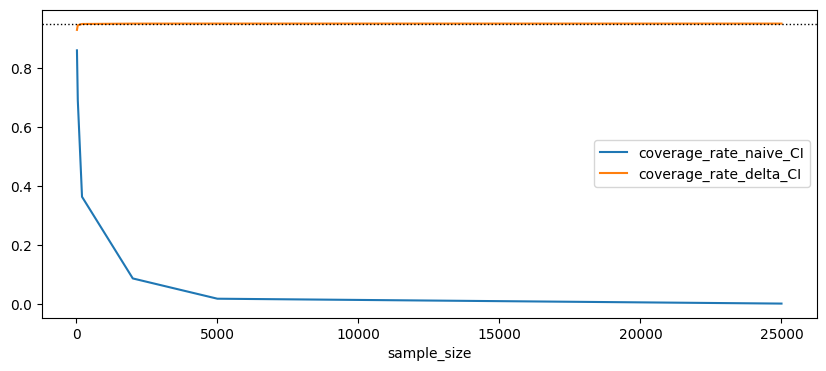

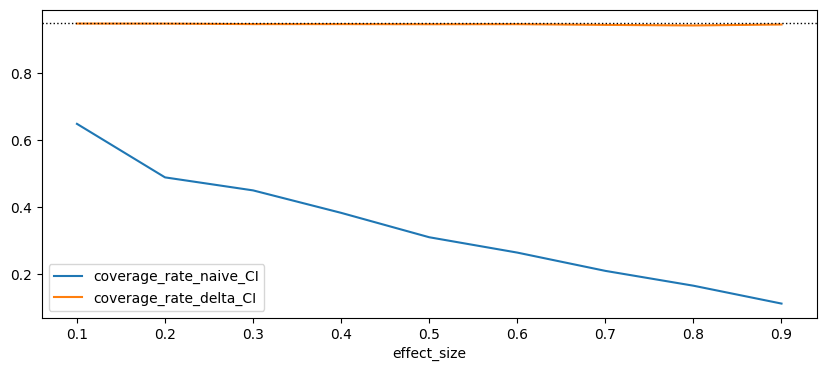

In [16]:
for col in ["sample_size", "effect_size"]:
    
    results.groupby(col, as_index=False) \
        .agg(
            coverage_rate_naive_CI=("is_naive_covered", "mean"),
            coverage_rate_delta_CI=("is_delta_covered", "mean")) \
        .plot(
            x=col,
            y=["coverage_rate_naive_CI", "coverage_rate_delta_CI"],
            figsize=(10, 4)
        )

    plt.axhline(
        y=0.95,
        color="k",
        linestyle="dotted",
        linewidth=1
    )

- The delta method CI converges very quickly towards nominal coverage rate
- The naive approach is way off; for moderate to big sample & effect sizes it's not reliable at all
- One should be careful when reporting results from an experiment 